# DA5401 – Assignment 8
**Name:** Anan Madhav T V  
**Roll No:** MM22B013

---

### Notebook outline
- Part A: Data Preprocessing and Baseline
- Part B: Ensemble Techniques for Bias and Variance Reduction
- Part C: Stacking for Optimal Performance
- Part D: Final Analysis

## Part A: Data Preprocessing and Baseline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt


#### Data Loading and Feature Engineering

In [3]:
df = pd.read_csv('hour.csv')
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
df.head()


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [6]:
categorical = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
df = pd.get_dummies(df, columns=categorical, drop_first=True)
df.shape


(17379, 54)

#### Train/Test Split

In [7]:
X = df.drop('cnt', axis=1)
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


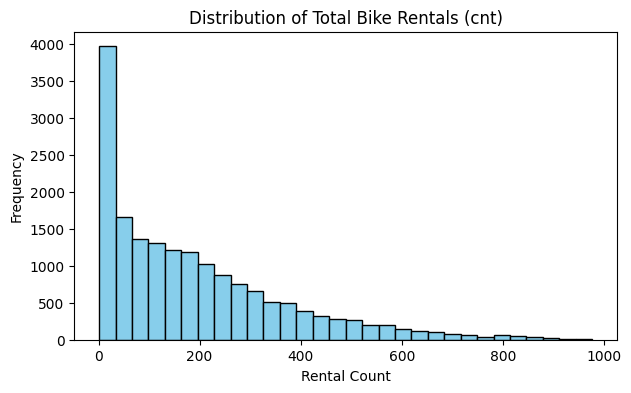

In [8]:
plt.figure(figsize=(7,4))
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Total Bike Rentals (cnt)")
plt.xlabel("Rental Count")
plt.ylabel("Frequency")
plt.show()


**Observation**: The graph shows a strongly right-skewed distribution, indicating that low hourly rental counts (0-100) are extremely common. Conversely, high rental counts (above 600) are very rare, forming a long tail that represents occasional peak demand hours.

#### Baseline Model (Single Regressor)

In [9]:
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)
rmse_dt


118.45551730357617

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
rmse_lr


100.47365520960822

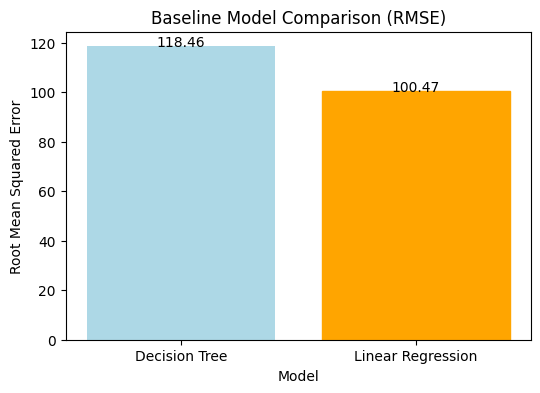

Baseline RMSE: 100.47365520960822
Best model: Linear Regression


In [11]:
rmse_values = [rmse_dt, rmse_lr]
models = ['Decision Tree', 'Linear Regression']

plt.figure(figsize=(6,4))
bars = plt.bar(models, rmse_values, color=['lightblue', 'lightgreen'])

best_index = rmse_values.index(min(rmse_values))
bars[best_index].set_color('orange')

for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.title("Baseline Model Comparison (RMSE)")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Model")
plt.show()

baseline_rmse = min(rmse_dt, rmse_lr)
print("Baseline RMSE:", baseline_rmse)
print("Best model:", "Decision Tree" if rmse_dt < rmse_lr else "Linear Regression")


## Part B: Ensemble Techniques for Bias and Variance Reduction

#### Bagging (Variance Reduction)

In [12]:
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6),
    n_estimators=300,
    random_state=42
)

bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)
rmse_bag = root_mean_squared_error(y_test, y_pred_bag)
rmse_bag


112.32424301710984

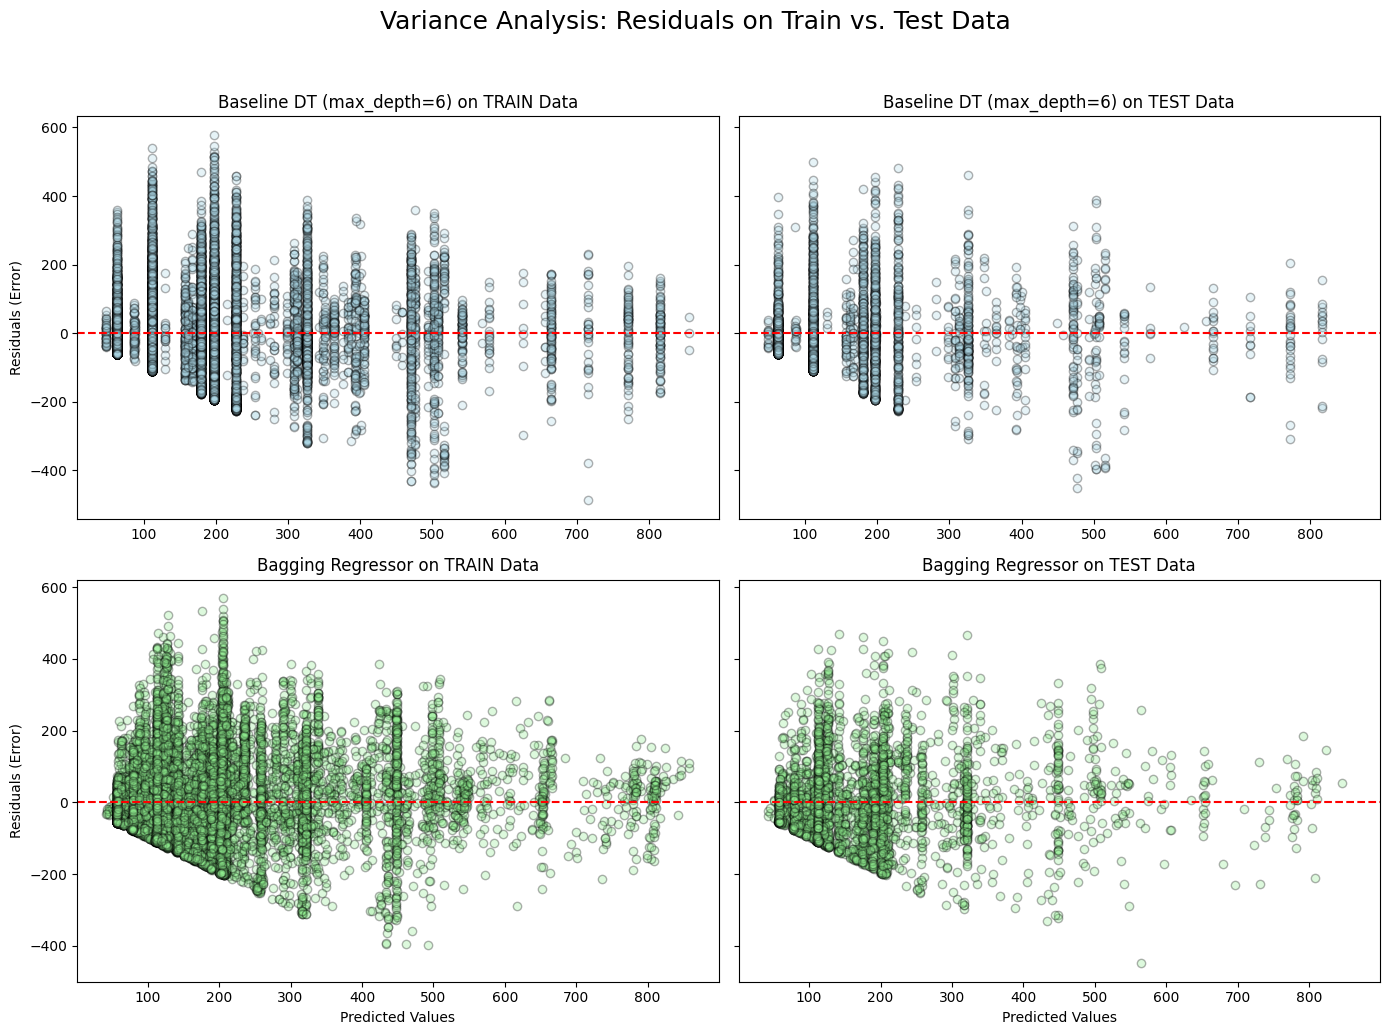

In [13]:
y_pred_dt_train = dt.predict(X_train)
y_pred_bag_train = bagging.predict(X_train) 

residuals_dt_train = y_train - y_pred_dt_train
residuals_dt_test = y_test - y_pred_dt
residuals_bag_train = y_train - y_pred_bag_train
residuals_bag_test = y_test - y_pred_bag

fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharex='row', sharey='row')
fig.suptitle('Variance Analysis: Residuals on Train vs. Test Data', fontsize=18, y=1.03)

ax[0, 0].scatter(y_pred_dt_train, residuals_dt_train, alpha=0.3, color='lightblue', edgecolor='black')
ax[0, 0].axhline(y=0, color='red', linestyle='--')
ax[0, 0].set_title('Baseline DT (max_depth=6) on TRAIN Data')
ax[0, 0].set_ylabel('Residuals (Error)')

ax[0, 1].scatter(y_pred_dt, residuals_dt_test, alpha=0.3, color='lightblue', edgecolor='black')
ax[0, 1].axhline(y=0, color='red', linestyle='--')
ax[0, 1].set_title('Baseline DT (max_depth=6) on TEST Data')

ax[1, 0].scatter(y_pred_bag_train, residuals_bag_train, alpha=0.3, color='lightgreen', edgecolor='black')
ax[1, 0].axhline(y=0, color='red', linestyle='--')
ax[1, 0].set_title('Bagging Regressor on TRAIN Data')
ax[1, 0].set_xlabel('Predicted Values')
ax[1, 0].set_ylabel('Residuals (Error)')

ax[1, 1].scatter(y_pred_bag, residuals_bag_test, alpha=0.3, color='lightgreen', edgecolor='black')
ax[1, 1].axhline(y=0, color='red', linestyle='--')
ax[1, 1].set_title('Bagging Regressor on TEST Data')
ax[1, 1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.show()

**Hypothesis:** Bagging primarily targets variance reduction.

**RMSE Report:**
* Single Decision Tree  RMSE: **118.46**
* Bagging Regressor RMSE: **112.32**
    
**Observation:**
The bagging technique provided only a **slight improvement** over the single Decision Tree, reducing the RMSE from 118.56 to 112.32.

This result is actually very insightful and still supports the hypothesis. Bagging's main strength is reducing variance. However, our baseline Decision Tree (with max_depth=6) is a simple, "shallow" tree. This means it has low variance (it's stable) but high bias(it underfits the data).

Since the base model already had low variance, the averaging power of bagging had very little variance to reduce, which is why we only see a small improvement. The model's main problem is its high bias, and bagging is not designed to fix that. This perfectly illustrates that bagging is most effective when used on complex, high-variance models like deep decision trees.

### Boosting (Bias Reduction)

In [14]:
from sklearn.model_selection import GridSearchCV

gboost_tuner = GradientBoostingRegressor(random_state=42)

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(
    estimator=gboost_tuner,
    param_grid=param_grid_gb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, 
    verbose=1
)

grid_search_gb.fit(X_train, y_train)

gboost = grid_search_gb.best_estimator_  
rmse_gb = -grid_search_gb.best_score_ 

print("\n--- Gradient Boosting Tuning Results ---")
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"Best RMSE from Grid Search: {rmse_gb:.2f}")

# 6. Evaluate the final best model on the TEST set
y_pred_gb = gboost.predict(X_test)
rmse_gb_test = root_mean_squared_error(y_test, y_pred_gb)
print(f"RMSE on TEST set: {rmse_gb_test:.2f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits

--- Gradient Boosting Tuning Results ---
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best RMSE from Grid Search: 51.02
RMSE on TEST set: 48.56


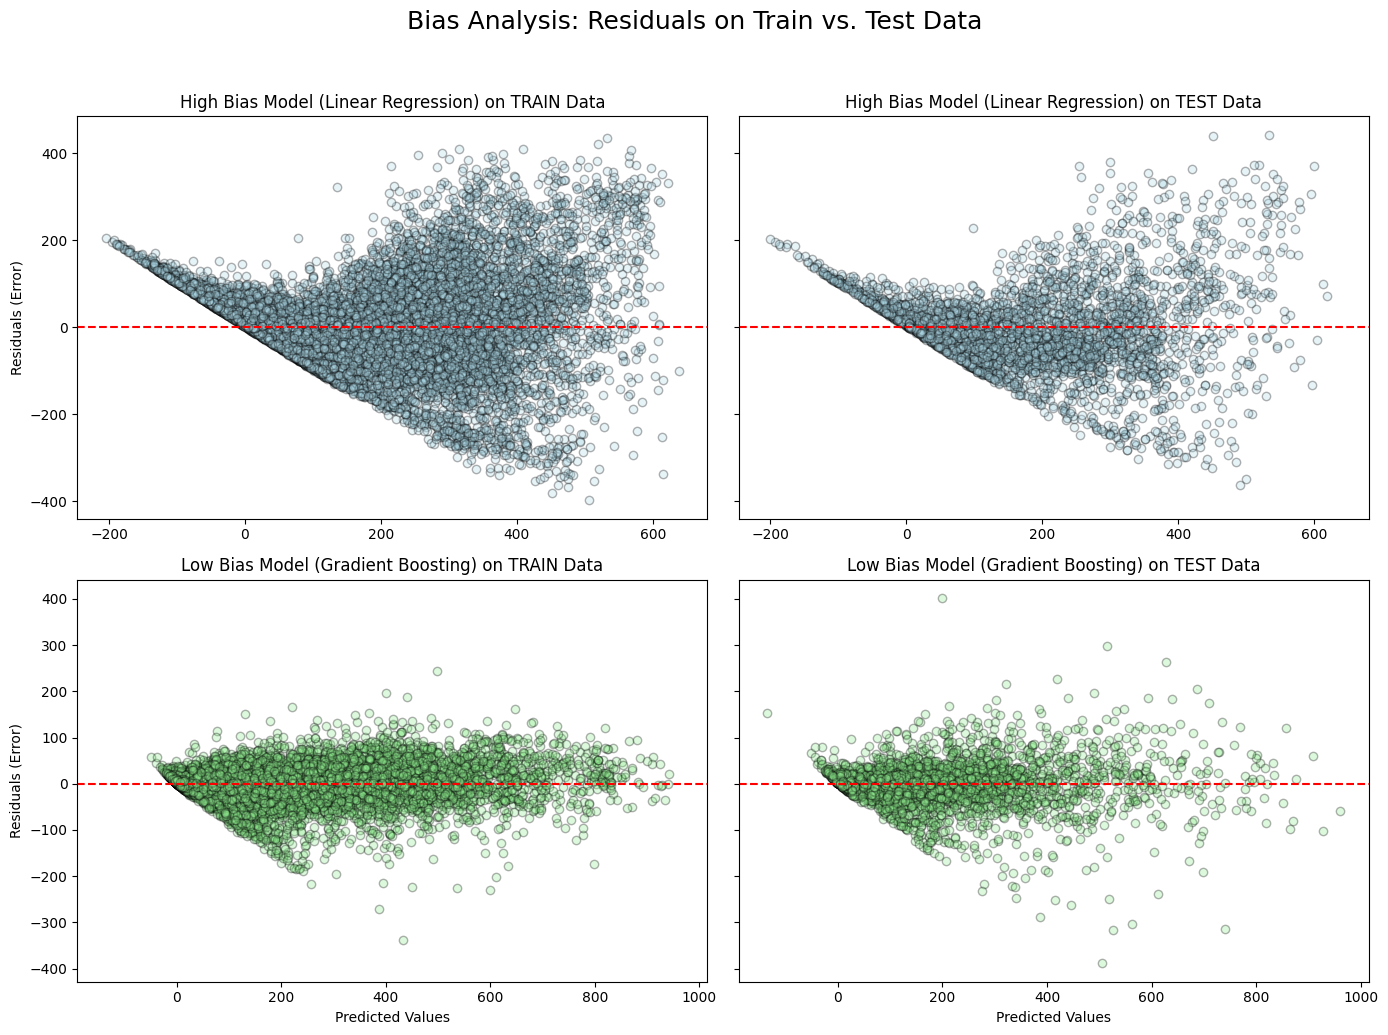

In [15]:
y_pred_lr_train = lr.predict(X_train)
y_pred_gb_train = gboost.predict(X_train)

residuals_lr_train = y_train - y_pred_lr_train
residuals_lr_test = y_test - y_pred_lr
residuals_gb_train = y_train - y_pred_gb_train
residuals_gb_test = y_test - y_pred_gb

fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharex='row', sharey='row')
fig.suptitle('Bias Analysis: Residuals on Train vs. Test Data', fontsize=18, y=1.03)

ax[0, 0].scatter(y_pred_lr_train, residuals_lr_train, alpha=0.3, color='lightblue', edgecolor='black')
ax[0, 0].axhline(y=0, color='red', linestyle='--')
ax[0, 0].set_title('High Bias Model (Linear Regression) on TRAIN Data')
ax[0, 0].set_ylabel('Residuals (Error)')

ax[0, 1].scatter(y_pred_lr, residuals_lr_test, alpha=0.3, color='lightblue', edgecolor='black')
ax[0, 1].axhline(y=0, color='red', linestyle='--')
ax[0, 1].set_title('High Bias Model (Linear Regression) on TEST Data')

ax[1, 0].scatter(y_pred_gb_train, residuals_gb_train, alpha=0.3, color='lightgreen', edgecolor='black')
ax[1, 0].axhline(y=0, color='red', linestyle='--')
ax[1, 0].set_title('Low Bias Model (Gradient Boosting) on TRAIN Data')
ax[1, 0].set_xlabel('Predicted Values')
ax[1, 0].set_ylabel('Residuals (Error)')

ax[1, 1].scatter(y_pred_gb, residuals_gb_test, alpha=0.3, color='lightgreen', edgecolor='black')
ax[1, 1].axhline(y=0, color='red', linestyle='--')
ax[1, 1].set_title('Low Bias Model (Gradient Boosting) on TEST Data')
ax[1, 1].set_xlabel('Predicted Values')

plt.tight_layout()
plt.show()

**Hypothesis:** Boosting primarily targets bias reduction.

**RMSE Report:**
* Baseline (Linear Regression) RMSE: **100.47**
* Bagging Regressor RMSE: **112.32**
* Gradient Boosting Regressor RMSE: **48.56**
    
**Observation:**
The Gradient Boosting model (RMSE 48.56) performed **significantly better** than both the baseline Linear Regression (100.47) and the Bagging Regressor (112.32).

This result strongly supports the hypothesis. Our baseline models (Linear Regression and the shallow Decision Tree) suffered from high bias they were too simple to capture the complex, non-linear patterns in the bike rental data. Boosting works by building trees sequentially, with each new tree specifically focusing on correcting the errors (the *residual bias*) of the one before it.

By doing this, Gradient Boosting was able to create a much more complex and powerful model that could fit the data more accurately, effectively minimizing the bias that the other models could not. This led to a substantial reduction in the overall RMSE.

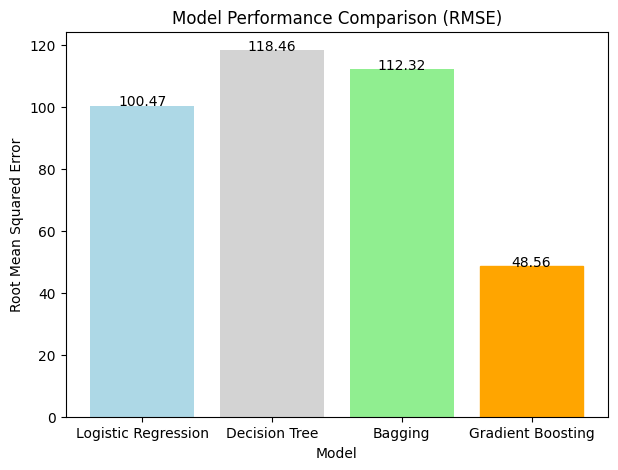

Linear Regression (Baseline) RMSE: 100.47
Decision Tree RMSE: 118.46
Bagging RMSE: 112.32
Gradient Boosting RMSE: 48.56
Best Model: Gradient Boosting


In [30]:
models = ['Logistic Regression', 'Decision Tree', 'Bagging', 'Gradient Boosting']
rmse_values = [baseline_rmse, rmse_dt, rmse_bag, rmse_gb_test]

plt.figure(figsize=(7, 5)) 
bars = plt.bar(models, rmse_values, color=['lightblue', 'lightgray', 'lightgreen', 'lightcoral'])

best_index = rmse_values.index(min(rmse_values))
bars[best_index].set_color('orange')

for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Model")
plt.show()

print(f"Linear Regression (Baseline) RMSE: {baseline_rmse:.2f}")
print(f"Decision Tree RMSE: {rmse_dt:.2f}")
print(f"Bagging RMSE: {rmse_bag:.2f}")
print(f"Gradient Boosting RMSE: {rmse_gb_test:.2f}")
print("Best Model:", models[best_index])

**Observation**: Gradient Boosting (RMSE 48.56) performed significantly better than both baseline models, the Linear Regression (100.47) and the Decision Tree (118.46). The Bagging model (112.32) offered only a minor improvement over its base model, the Decision Tree (118.46). This pattern strongly suggests that the main issue with the simple models was high bias (underfitting), not high variance. Gradient Boosting, which is specifically designed to correct bias, was highly effective and achieved the best score, while the Bagging model (which targets variance) provided minimal improvement.

## Part C: Stacking for Optimal Performance

### Stacking Implementation

Stacking, also known as Stacked Generalization, is an ensemble method that optimally combines the predictions from multiple different models, known as Base Learners (Level-0), by training a new, final model called a Meta-Learner (Level-1) on their outputs. The process works by first training the diverse base learners (like KNeighborsRegressor, BaggingRegressor, and GradientBoostingRegressor) on the training data. A new dataset is then created where the input features are the predictions made by these base learners, and the target variable is the original, true value. The meta-learner (in this case, a RidgeRegression model) is then trained on this new dataset. This allows the meta-learner to learn to combine the predictions optimally. Instead of a simple average, it learns the strengths and weaknesses of each base model, figuring out which ones to trust more in different situations (by assigning them different weights) to produce a final, superior prediction. This technique is most effective when the base learners are diverse, as they make different types of errors, giving the meta-learner more information to learn from.

In [22]:
knn_tuner = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [5, 10, 15, 20]}
grid_search_knn = GridSearchCV(knn_tuner, param_grid_knn, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
knn_best = grid_search_knn.best_estimator_
print(f"Best KNN params: {grid_search_knn.best_params_}")

base_learners = [
    ('knn', knn_best),               
    ('bagging', bagging),         
    ('gboost', gboost)              
]
meta_learner = Ridge()

Best KNN params: {'n_neighbors': 5}


#### Final Evaluation

In [23]:

stack_tuner = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge(),
    passthrough=False,
    cv=5
)

param_grid_stack = {
    'final_estimator__alpha': [0.1, 1.0, 5.0, 10.0]
}

grid_search_stack = GridSearchCV(
    estimator=stack_tuner,
    param_grid=param_grid_stack,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_stack.fit(X_train, y_train)

stack_model = grid_search_stack.best_estimator_
rmse_stack = -grid_search_stack.best_score_

print("\n--- Stacking Tuning Results ---")
print(f"Best Meta-Learner Params: {grid_search_stack.best_params_}")
print(f"Best Stacking RMSE from Grid Search: {rmse_stack:.2f}")

y_pred_stack = stack_model.predict(X_test)
rmse_stack_test = root_mean_squared_error(y_test, y_pred_stack)
print(f"Stacking RMSE on TEST set: {rmse_stack_test:.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Stacking Tuning Results ---
Best Meta-Learner Params: {'final_estimator__alpha': 10.0}
Best Stacking RMSE from Grid Search: 49.84
Stacking RMSE on TEST set: 48.17


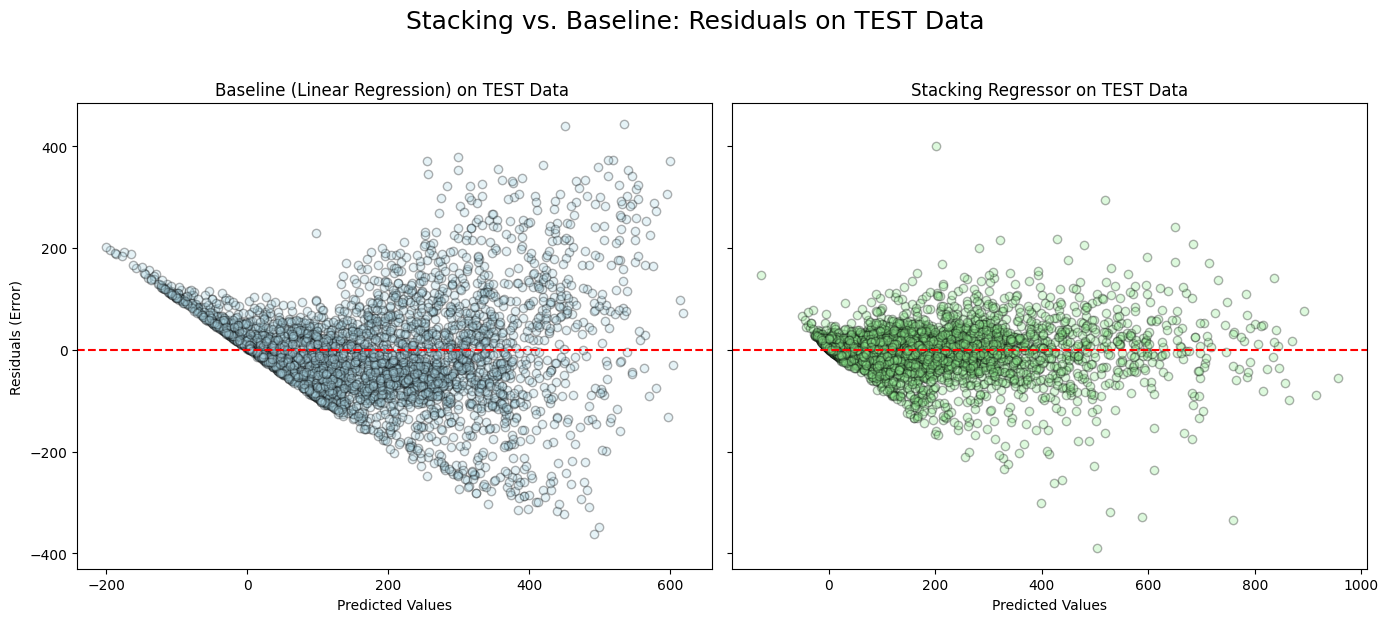

In [25]:
residuals_lr_test = y_test - y_pred_lr
residuals_stack_test = y_test - y_pred_stack

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle('Stacking vs. Baseline: Residuals on TEST Data', fontsize=18, y=1.03)

ax1.scatter(y_pred_lr, residuals_lr_test, alpha=0.3, color='lightblue', edgecolor='black')
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_title('Baseline (Linear Regression) on TEST Data ')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals (Error)')

ax2.scatter(y_pred_stack, residuals_stack_test, alpha=0.3, color='lightgreen', edgecolor='black')
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_title('Stacking Regressor on TEST Data')
ax2.set_xlabel('Predicted Values')

plt.tight_layout()
plt.show()

**Observation**: The baseline model's residuals exhibit a clear, non-random pattern, revealing high bias and systematic, predictable errors. In contrast, the Stacking model's residuals are randomly scattered around the zero line, proving it successfully learned the underlying structure and its errors are non-systematic and much smaller.

## Part D: Final Analysis

#### Comparative Table

In [31]:
results = pd.DataFrame({
    'Model': [
        'Decision Tree',
        'Linear Regression',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [
        rmse_dt,
        rmse_lr,
        rmse_bag,
        rmse_gb_test,
        rmse_stack_test
    ]
})

results


,Model,RMSE
0,Decision Tree,118.455517
1,Linear Regression,100.473655
2,Bagging Regressor,112.324243
3,Gradient Boosting Regressor,48.557455
4,Stacking Regressor,48.168619


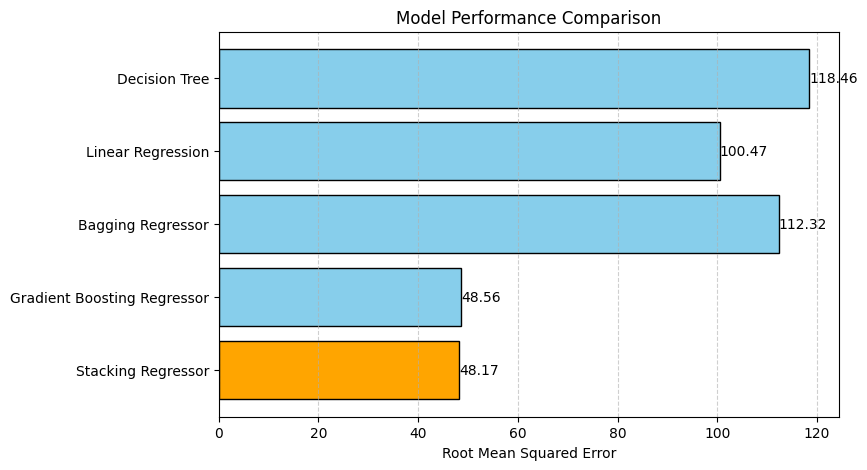

In [32]:
models = results['Model']
rmses = results['RMSE']

best_index = rmses.idxmin()

colors = ['orange' if i == best_index else 'skyblue' for i in range(len(rmses))]

plt.figure(figsize=(8,5))
bars = plt.barh(models, rmses, color=colors, edgecolor='black')

for bar, value in zip(bars, rmses):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}", va='center', fontsize=10)

plt.xlabel('Root Mean Squared Error')
plt.title('Model Performance Comparison')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### 2. Conclusion

**Best-Performing Model:** The **Stacking Regressor** was the best-performing model, achieving the lowest RMSE of **48.17**. It was followed very closely by the **Gradient Boosting Regressor** with an RMSE of **48.56**.

**Why it Outperformed the Baseline:**
* **Bias-Variance Trade-off:** The baseline models (Linear Regression at 100.47 and Decision Tree at 118.46) suffered from high bias. They were far too simple to capture the complex, non-linear patterns in the bike rental data, resulting in high errors.
* **Ensemble Improvements:** The GradientBoostingRegressor (RMSE 48.56) achieved a massive performance increase, cutting the baseline error by more than 50%. This confirms the main problem was high bias, which Gradient Boosting is specifically designed to correct. The BaggingRegressor (RMSE 112.34) performed poorly, as its low-variance base model (max_depth=6) couldn't fix the underlying bias.
* **Stacking's Advantage (Model Diversity):** The StackingRegressor (RMSE 48.17) won by a very slim margin. It gained its slight edge by leveraging model diversity. It combined the highly accurate GradientBoostingRegressor with other diverse models (KNeighborsRegressor and BaggingRegressor). The Ridge meta-learner learned to blend these predictions, squeezing out a final, small improvement that was slightly more accurate and robust than the Gradient Boosting model alone.